In [1]:
import pandas as pd
import numpy as np

In [2]:
rats=[20382,24101,21012,22295,20630,22098,23783,24116]
path="../data_gen/"
df = pd.DataFrame()

In [3]:
for i in range(len(rats)):
    ratid=rats[i]
    data=pd.read_json(path+"Rat_"+str(ratid)+"_resrel_data.json",orient="records")
    #print(data.columns)
    data['LOC']=data['LOC'].apply(lambda x: x[-1])
    data['PInfo']=data['PInfo'].apply(lambda x: x['content'])
    data['HInfo']=data['HInfo'].apply(lambda x: x['content'])

    data['poss_PInfo']=data['poss_PInfo'].apply(lambda x: x['content'])
    data['poss_HInfo']=data['poss_HInfo'].apply(lambda x: x['content'])

    # Grouping and calculating mean or sum for specified columns based on group size
    grouped_df = data.groupby('NeuID')
    columns_to_mean = ['Nspikes', 'MSR', 'MHK','dt_MHK', 'OHK', 'OHS', 'dt_OHK', 'max_HSHK', 'PInfo', 'HInfo','poss_MSR', 'poss_MHK', 'poss_dt_MHK', 'poss_OHK', 'poss_OHS','poss_dt_OHK', 'poss_max_HSHK', 'poss_PInfo', 'poss_HInfo']
    tmp_df = pd.DataFrame()
    for name, group in grouped_df:
        if len(group) > 1:
            result_values = group[columns_to_mean].mean()
        else:
            result_values = group[columns_to_mean].sum()
        tmp_df = pd.concat([tmp_df, result_values.to_frame(name=name).T])
    tmp_df['RatID'] = tmp_df.index.map(data.drop_duplicates('NeuID').set_index('NeuID')['RAT_ID'])
    tmp_df['LOC'] = tmp_df.index.map(data.drop_duplicates('NeuID').set_index('NeuID')['LOC'])
    tmp_df['task'] = tmp_df.index.map(data.drop_duplicates('NeuID').set_index('NeuID')['task'])
    columns = tmp_df.columns.tolist()
    tmp_df=tmp_df[ columns[-3:] + columns[:-3]]
    tmp_df.reset_index(inplace=True)
    tmp_df.rename(columns={'index': 'NeuID'}, inplace=True)
    #print(df.columns)
    df = pd.concat([df,tmp_df], ignore_index=True)


In [4]:
df.columns

Index(['NeuID', 'RatID', 'LOC', 'task', 'Nspikes', 'MSR', 'MHK', 'dt_MHK',
       'OHK', 'OHS', 'dt_OHK', 'max_HSHK', 'PInfo', 'HInfo', 'poss_MSR',
       'poss_MHK', 'poss_dt_MHK', 'poss_OHK', 'poss_OHS', 'poss_dt_OHK',
       'poss_max_HSHK', 'poss_PInfo', 'poss_HInfo'],
      dtype='object')

In [5]:
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams.update(mpl.rcParamsDefault)

In [6]:
mss=120
fontssize=50
mpl.rcParams.update({
    'figure.figsize': (23.6,12.6),
    'font.family': 'serif',
    'font.serif': ['Palatino', 'Georgia'],  # Add or remove font names as needed
    'font.size': fontssize,  # Adjust as needed
    'font.weight': 'bold',
    "svg.fonttype": 'none',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amsfonts} \usepackage{cmbright}',
    'xtick.labelsize' : fontssize, # fontsize of the x tick labels
    'ytick.labelsize' : fontssize # fontsize of the y tick labels
})
ticks_font = font_manager.FontProperties(family='Palatino', style='normal',
    size=fontssize, weight='bold', stretch='normal')

Number of spikes-0, poss_MSR_opt-1,MSR-2,MHK-6,OHK-4,OHS-3,OHK+OHS-5

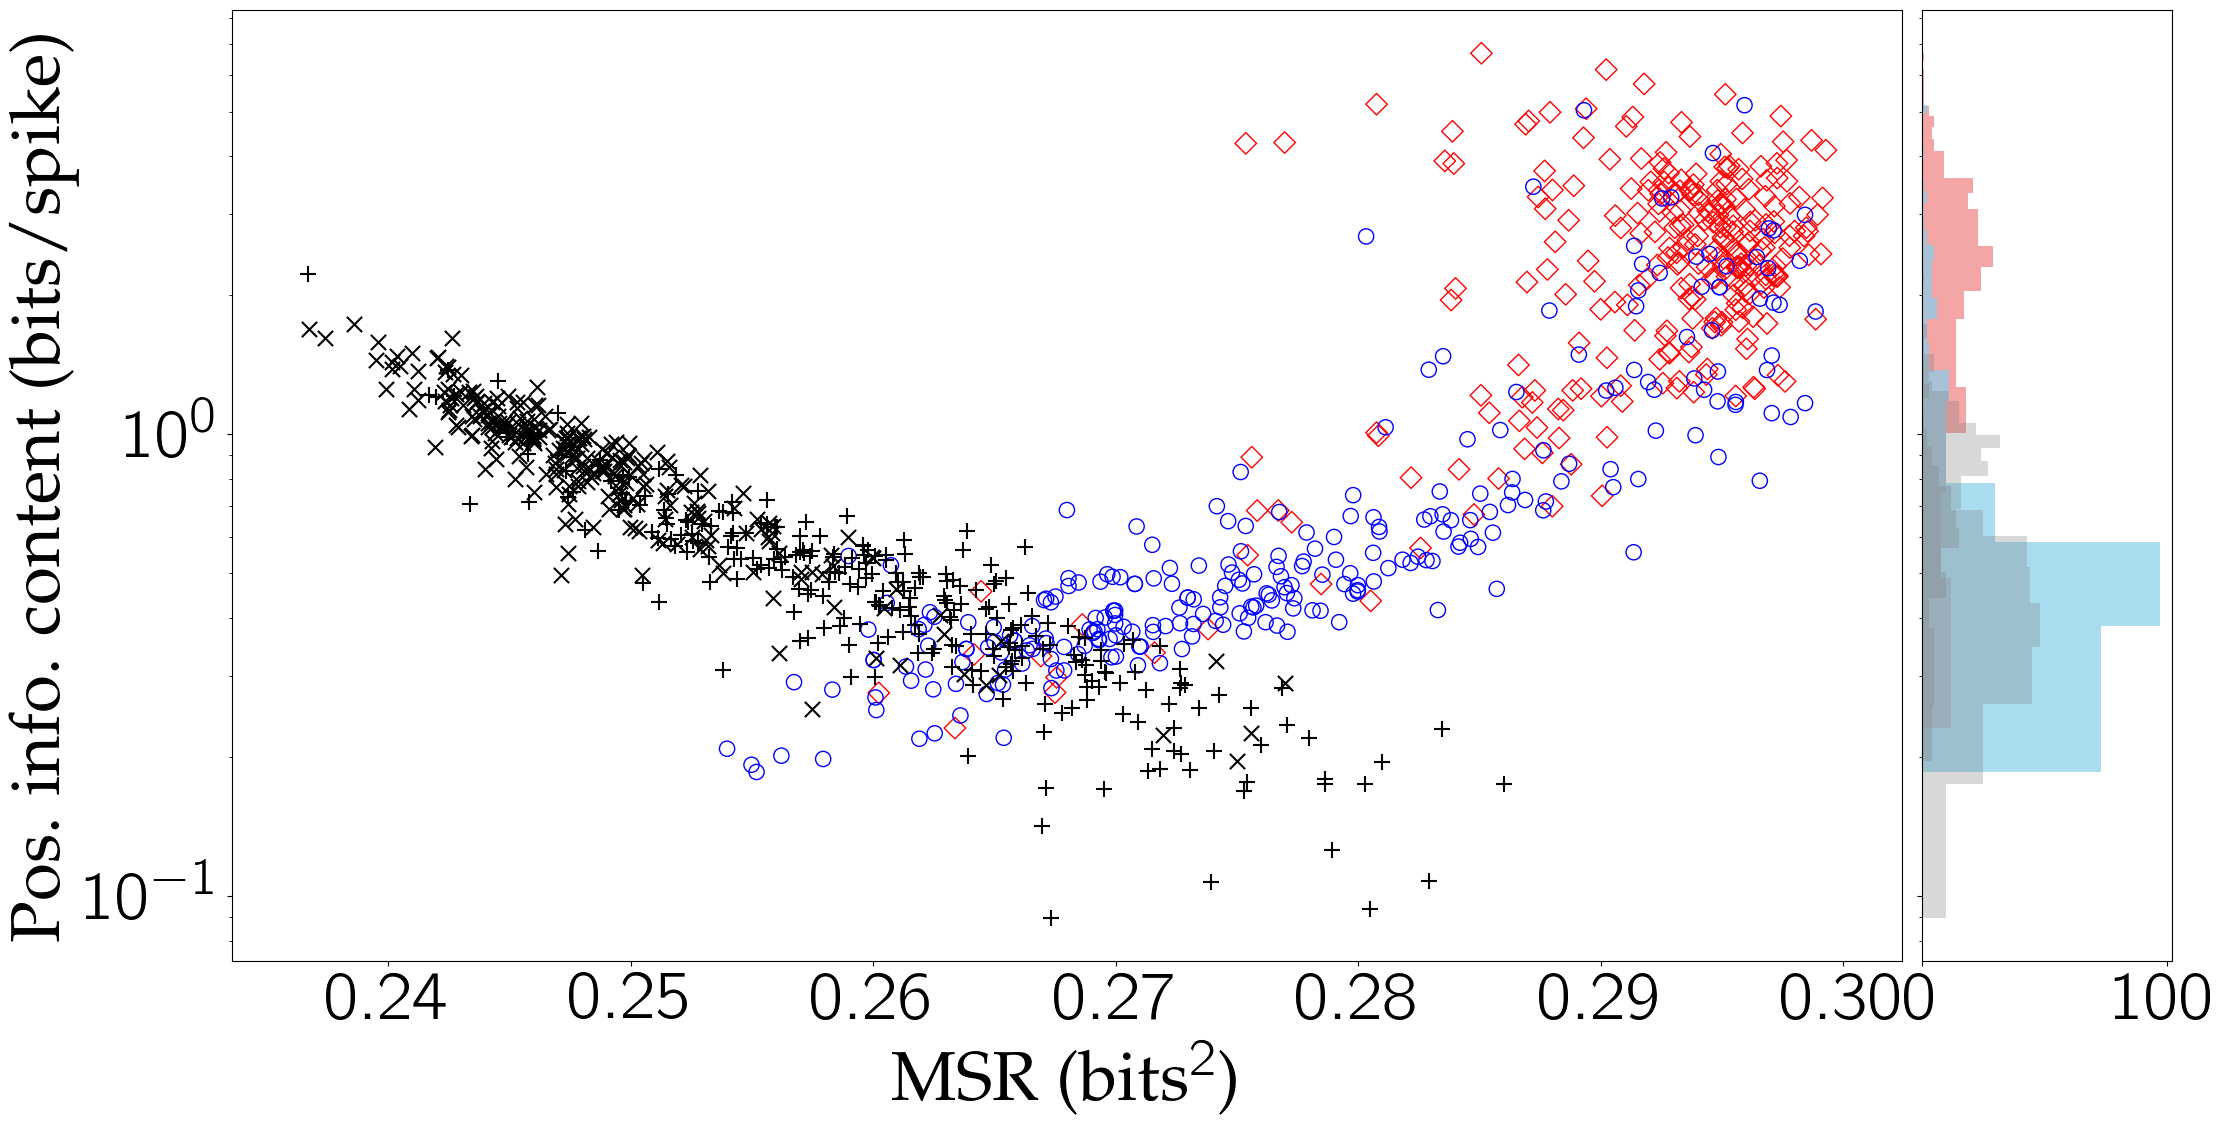

In [7]:
# Create scatter plot
fig, ax = plt.subplots()

quantX='MSR'
quantX_lab=r'MSR (bits$^2$)'

quantY='PInfo'
quantY_lab='Pos. info. content (bits/spike)'

figname='../figures/Fig2A.svg'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig2C.png'



# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')[quantX], df.query('LOC=="CA1"')[quantY], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')[quantX], df.query('LOC=="SUB"')[quantY], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['poss_'+quantX], df.query('LOC=="CA1"')['poss_'+quantY], label='rand. CA1 Neurons', marker='+', color='k',s=mss)
ax.scatter(df.query('LOC=="SUB"')['poss_'+quantX], df.query('LOC=="SUB"')['poss_'+quantY], label='rand. SUB Neurons', marker='x',color='k',s=mss)


# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.2, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
ax_histy.hist(df.query('LOC=="CA1"')[quantY], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quantY], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quantY], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quantY], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel(quantX_lab,fontsize=fontssize)
ax.set_ylabel(quantY_lab,fontsize=fontssize)  # Adjusted Y-axis label
ax.set_yscale('log')
# ax.set_xlim(0.1, 0.51)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.18), ncol=2,fontsize=22)

plt.tight_layout()
plt.savefig(figname,dpi=300)
# plt.savefig(figname2,dpi=300)

plt.show()

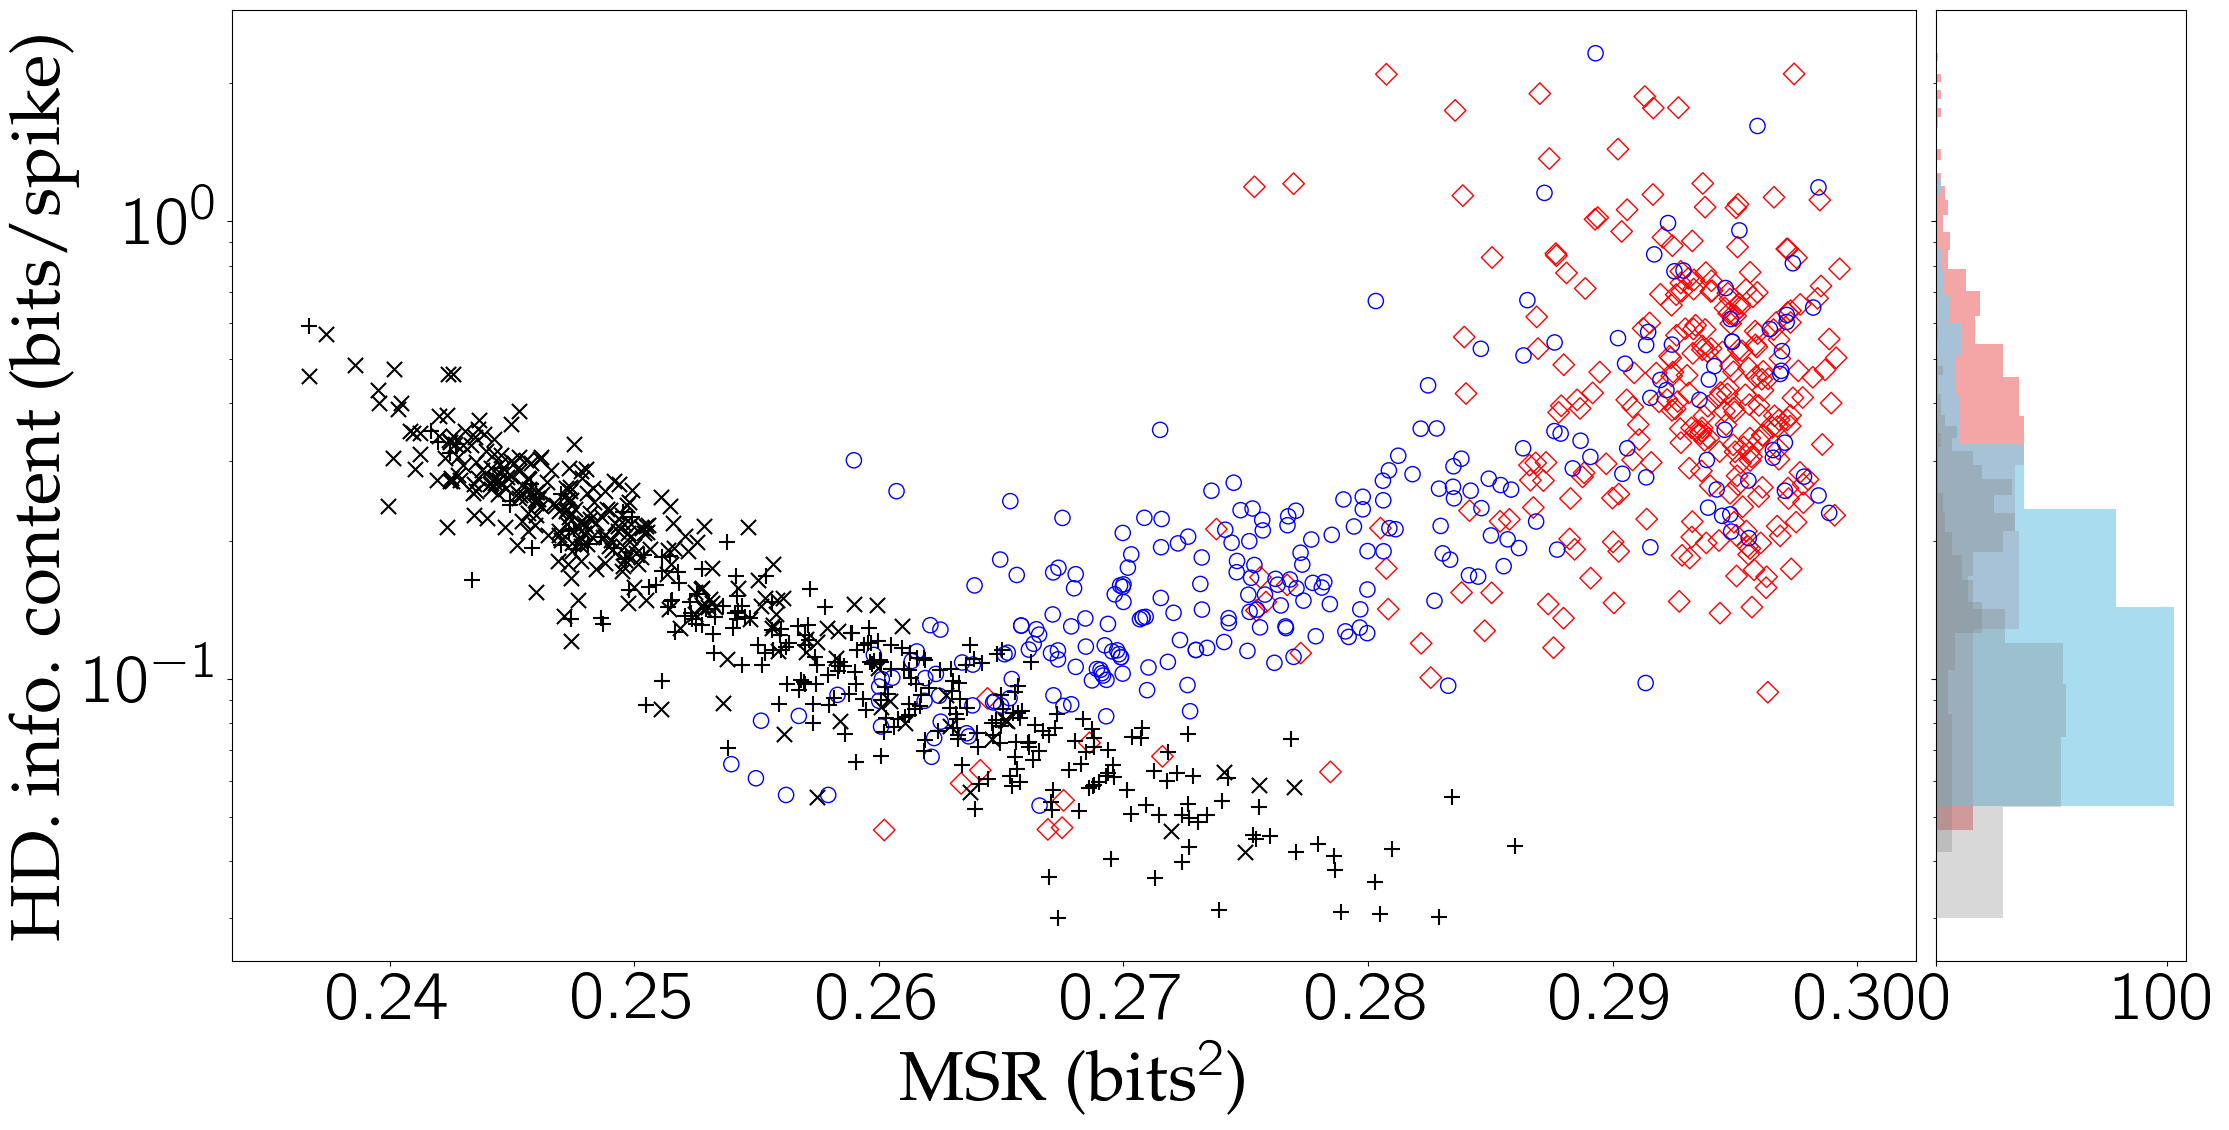

In [8]:
# Create scatter plot
fig, ax = plt.subplots()

quantX='MSR'
quantX_lab=r'MSR (bits$^2$)'

quantY='HInfo'
quantY_lab='HD. info. content (bits/spike)'

figname='../figures/Fig2B.svg'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig2C.png'



# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')[quantX], df.query('LOC=="CA1"')[quantY], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')[quantX], df.query('LOC=="SUB"')[quantY], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['poss_'+quantX], df.query('LOC=="CA1"')['poss_'+quantY], label='rand. CA1 Neurons', marker='+', color='k',s=mss)
ax.scatter(df.query('LOC=="SUB"')['poss_'+quantX], df.query('LOC=="SUB"')['poss_'+quantY], label='rand. SUB Neurons', marker='x',color='k',s=mss)


# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.2, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
ax_histy.hist(df.query('LOC=="CA1"')[quantY], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quantY], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quantY], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quantY], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel(quantX_lab,fontsize=fontssize)
ax.set_ylabel(quantY_lab,fontsize=fontssize)  # Adjusted Y-axis label
ax.set_yscale('log')
# ax.set_xlim(0.1, 0.51)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.18), ncol=2,fontsize=22)

plt.tight_layout()
plt.savefig(figname,dpi=300)
# plt.savefig(figname2,dpi=300)

plt.show()

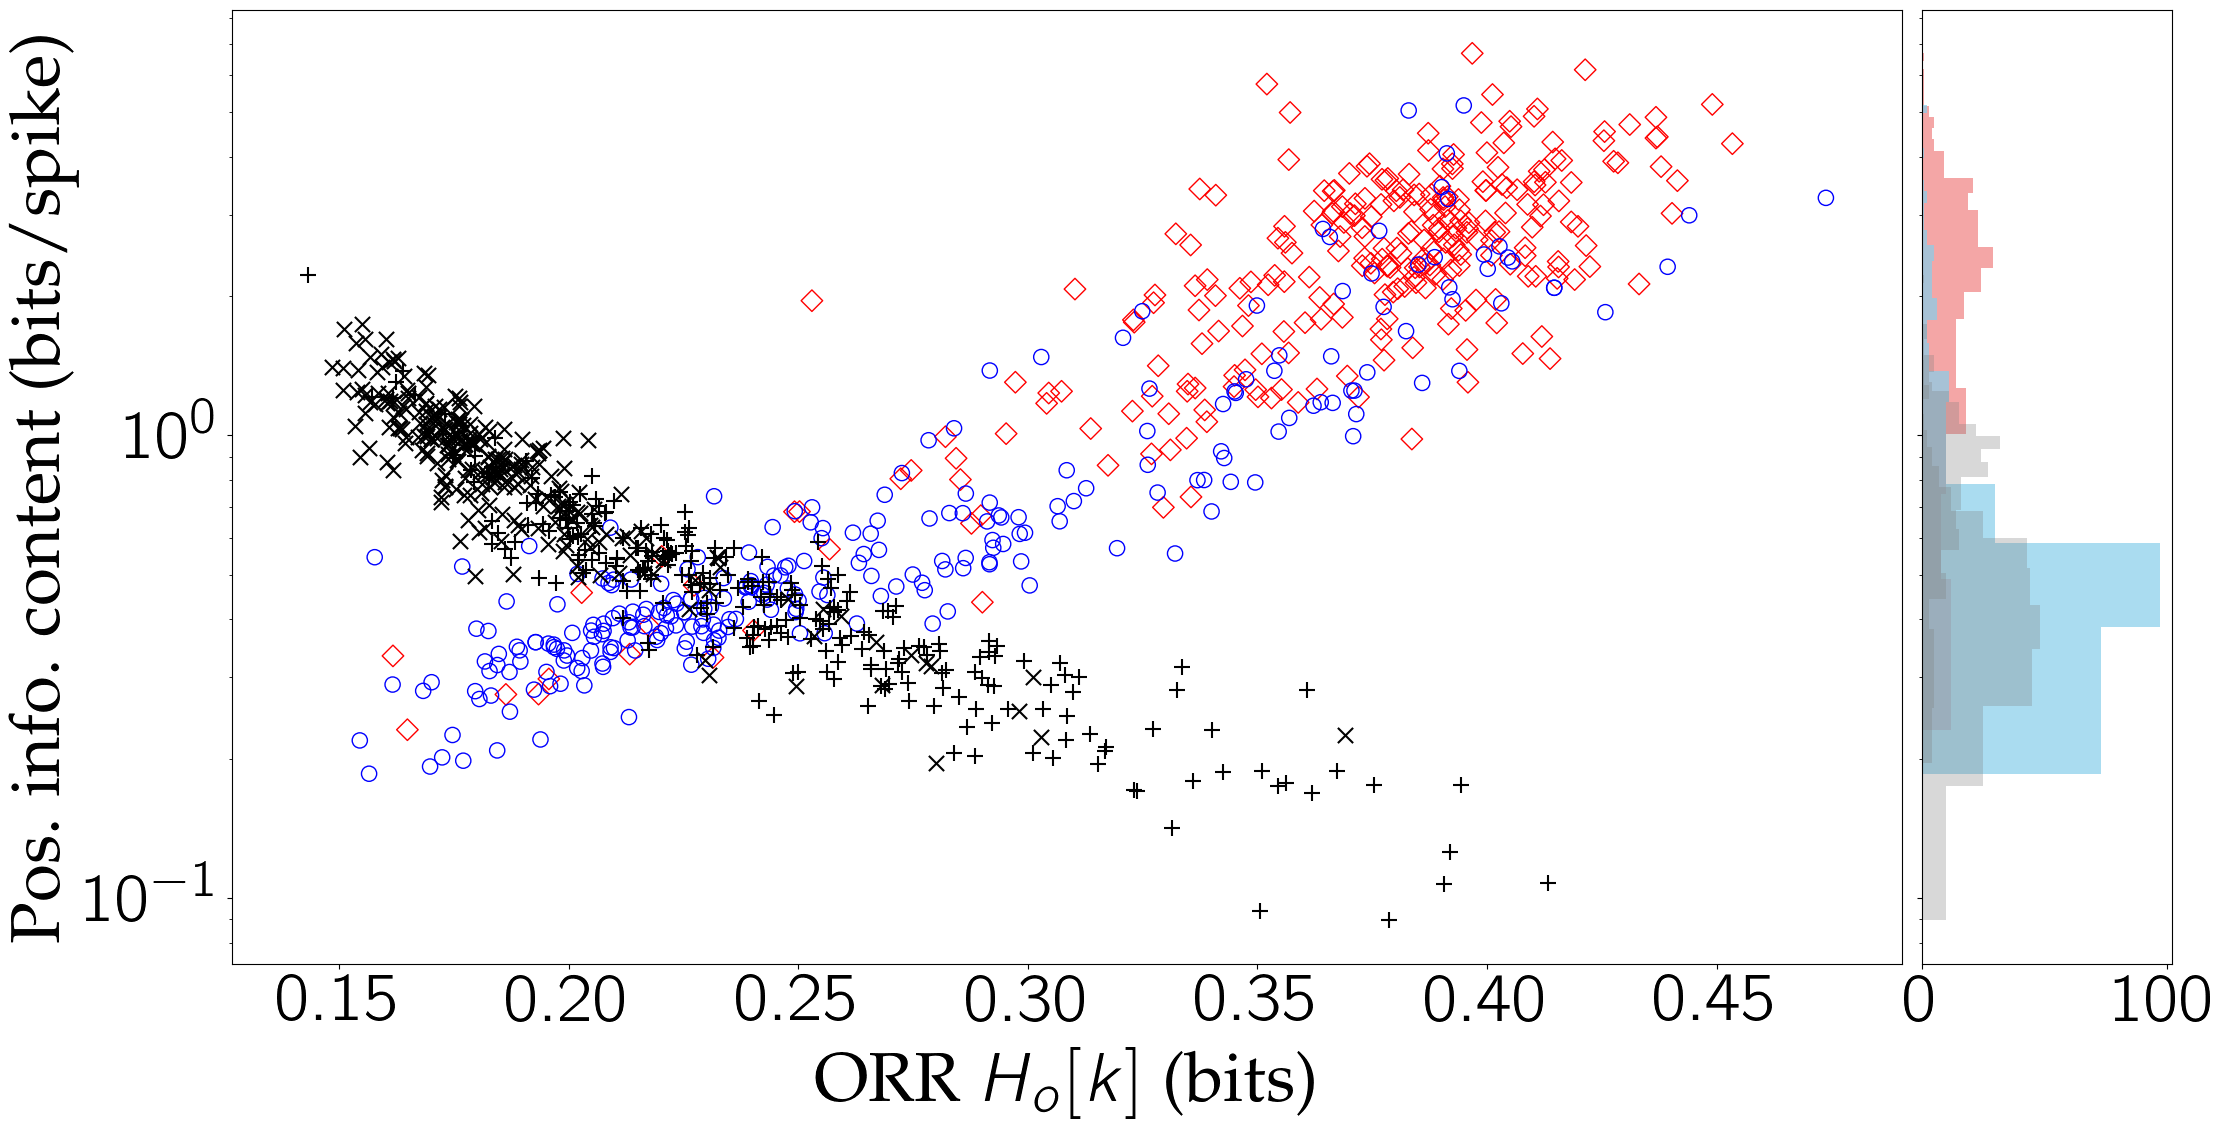

In [9]:
# Create scatter plot
fig, ax = plt.subplots()

quantX='OHK'
quantX_lab=r'ORR $H_o[k]$ (bits)'

quantY='PInfo'
quantY_lab='Pos. info. content (bits/spike)'

figname='../figures/Fig2C.svg'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig2C.png'



# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')[quantX], df.query('LOC=="CA1"')[quantY], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')[quantX], df.query('LOC=="SUB"')[quantY], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['poss_'+quantX], df.query('LOC=="CA1"')['poss_'+quantY], label='rand. CA1 Neurons', marker='+', color='k',s=mss)
ax.scatter(df.query('LOC=="SUB"')['poss_'+quantX], df.query('LOC=="SUB"')['poss_'+quantY], label='rand. SUB Neurons', marker='x',color='k',s=mss)


# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.2, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
ax_histy.hist(df.query('LOC=="CA1"')[quantY], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quantY], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quantY], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quantY], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel(quantX_lab,fontsize=fontssize)
ax.set_ylabel(quantY_lab,fontsize=fontssize)  # Adjusted Y-axis label
ax.set_yscale('log')
#ax.set_xlim(0.1, 0.5)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.18), ncol=2,fontsize=22)

plt.tight_layout()
plt.savefig(figname,dpi=300)
# plt.savefig(figname2,dpi=300)

plt.show()

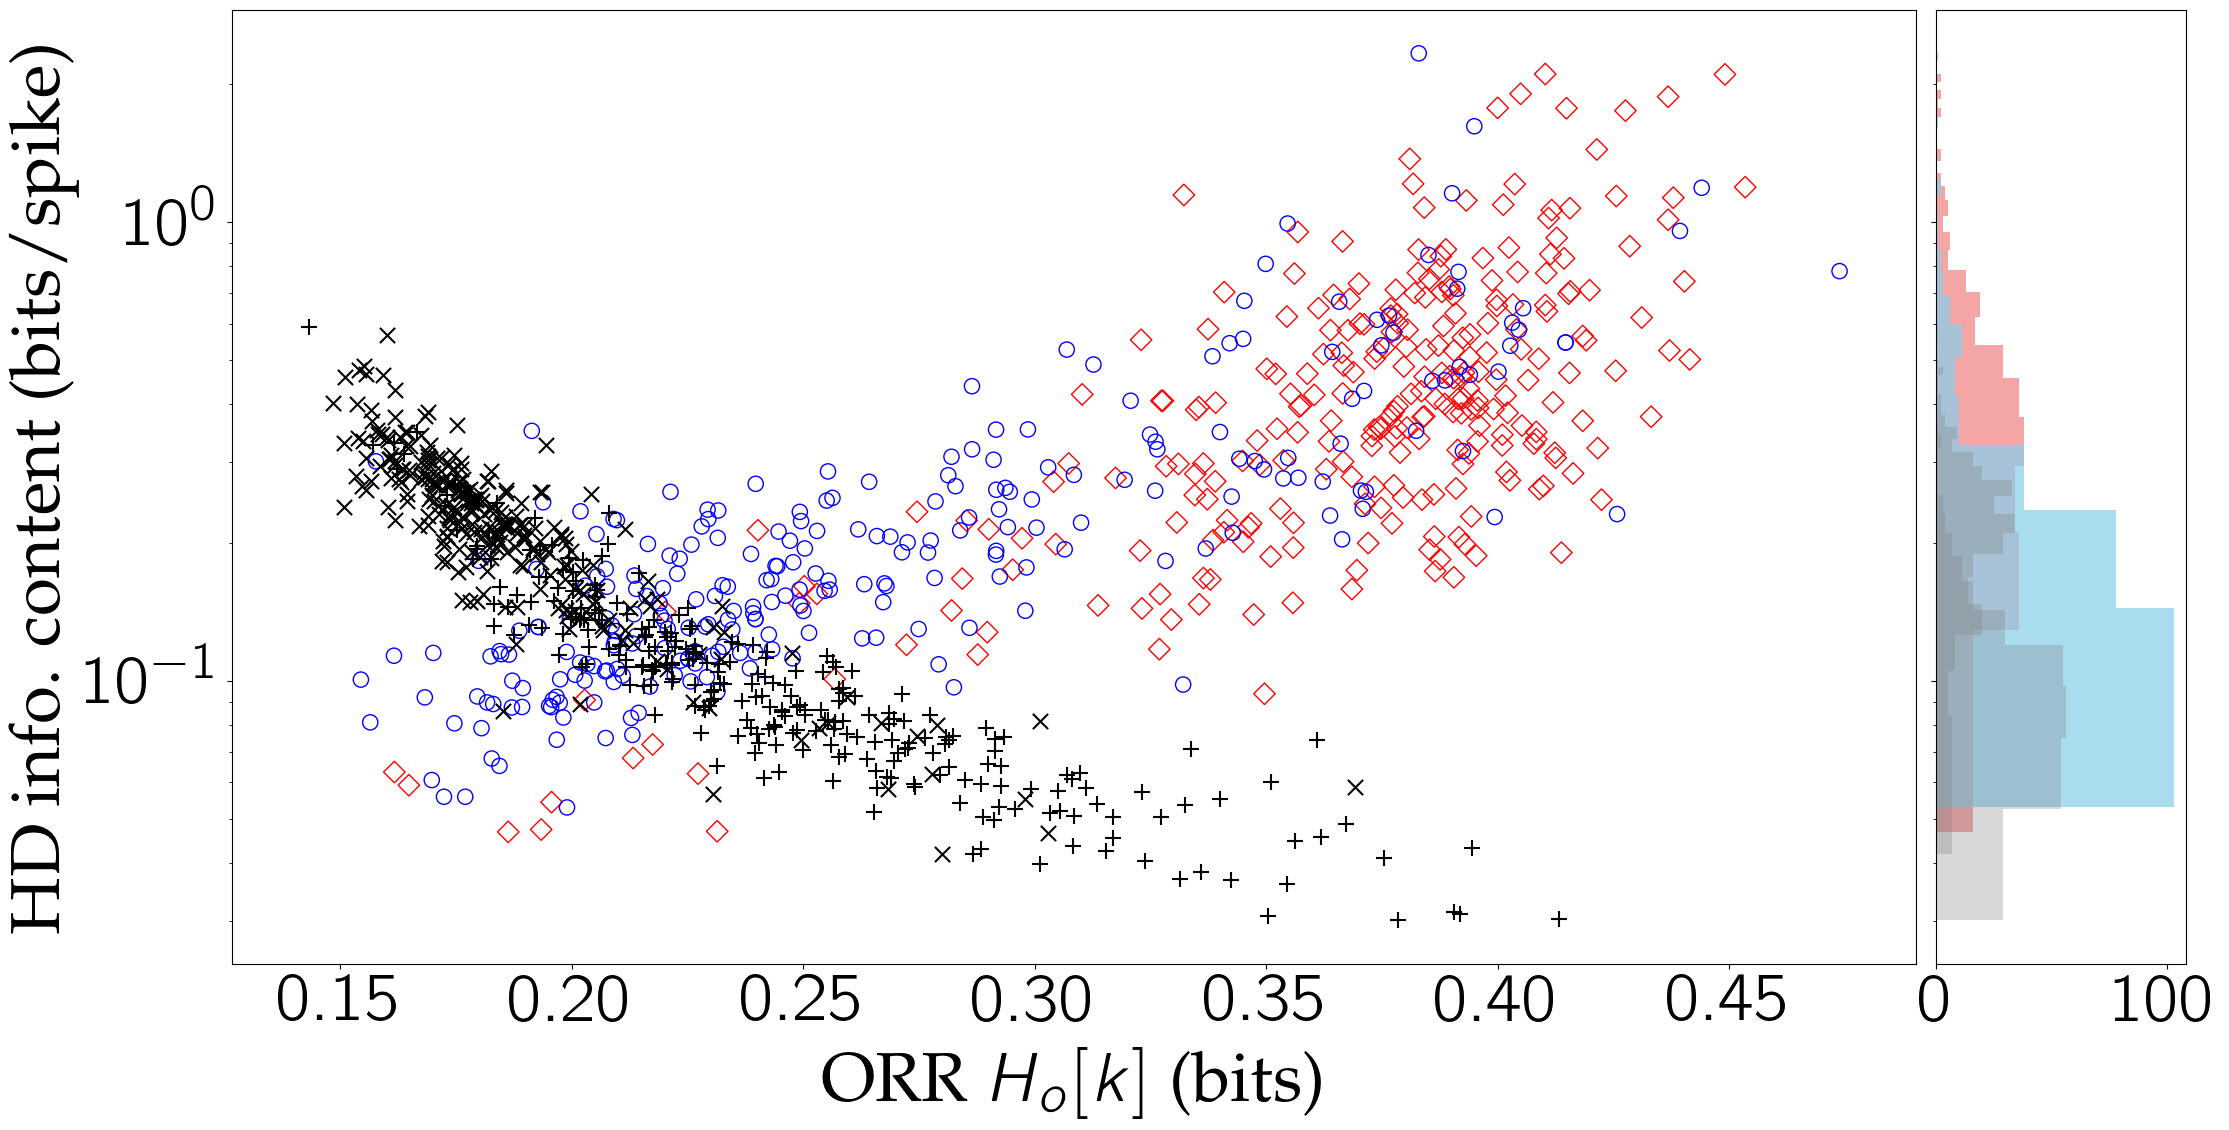

In [10]:
# Create scatter plot
fig, ax = plt.subplots()

quantX='OHK'
quantX_lab=r'ORR $H_o[k]$ (bits)'

quantY='HInfo'
quantY_lab='HD info. content (bits/spike)'

figname='../figures/Fig2D.svg'
#figname2='../../../../Apps/Overleaf/Project_Relevance_of_CA1_SUB/img/Fig2C.png'



# Scatter plot for 'quant' data
ax.scatter(df.query('LOC=="CA1"')[quantX], df.query('LOC=="CA1"')[quantY], label='CA1 Neurons', marker='D', facecolors='none',edgecolors='r',s=mss)
ax.scatter(df.query('LOC=="SUB"')[quantX], df.query('LOC=="SUB"')[quantY], label='SUB Neurons', marker='o', facecolors='none',edgecolors='b',s=mss)
# Scatter plot for 'poss_MSR' data
ax.scatter(df.query('LOC=="CA1"')['poss_'+quantX], df.query('LOC=="CA1"')['poss_'+quantY], label='rand. CA1 Neurons', marker='+', color='k',s=mss)
ax.scatter(df.query('LOC=="SUB"')['poss_'+quantX], df.query('LOC=="SUB"')['poss_'+quantY], label='rand. SUB Neurons', marker='x',color='k',s=mss)


# Create Marginal plot on the right-hand side
divider = make_axes_locatable(ax)
# Plot histogram on the right (for both sets of data)
ax_histy = divider.append_axes("right", 2.5, pad=0.2, sharey=ax)  # Adjusted pad value
# Remove y-axis label on the Marginal plot
ax_histy.tick_params(axis="y", labelleft=False)

# Plot histogram for 'quant' data
bins = 25
ax_histy.hist(df.query('LOC=="CA1"')[quantY], bins=bins, orientation='horizontal', color='lightcoral', edgecolor='none', alpha=0.7, label='CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')[quantY], bins=bins, orientation='horizontal', color='skyblue', edgecolor='none', alpha=0.7, label='SUB Neurons')

# Plot histogram for 'poss_quant' data
ax_histy.hist(df.query('LOC=="CA1"')['poss_'+quantY], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad CA1 Neurons')
ax_histy.hist(df.query('LOC=="SUB"')['poss_'+quantY], bins=bins, orientation='horizontal', color='grey', edgecolor='none', alpha=0.3, label='Rnad SUB Neurons')


# Set labels and title for the main scatter plot
ax.set_xlabel(quantX_lab,fontsize=fontssize)
ax.set_ylabel(quantY_lab,fontsize=fontssize)  # Adjusted Y-axis label
ax.set_yscale('log')
#ax.set_xlim(0.1, 0.5)

for tick in ax.get_xticklabels():
    tick.set_fontproperties(ticks_font)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(ticks_font)
    
# Add legend to the scatter plot outside, on the top, with horizontal layout and single column
# ax.legend(loc='upper center', bbox_to_anchor=(0.55, 1.18), ncol=2,fontsize=22)

plt.tight_layout()
plt.savefig(figname,dpi=300)
# plt.savefig(figname2,dpi=300)

plt.show()

In [11]:
import plotly.express as px


px.scatter(data_frame=df, x='MSR', y='poss_PInfo',color='LOC', log_x=True,hover_name="NeuID", hover_data=["RatID","task"],marginal_y='histogram')

#px.scatter(data_frame=data, x='Nspikes', y=['MSR','poss_MSR'],color='LOC', log_x=True,hover_name="NeuID", hover_data=["task"],marginal_y='histogram')

In [12]:
# px.scatter(data_frame=data, x='Nspikes', y=['MSR'],color='LOC', log_x=True,hover_name="NeuID", hover_data=["task"],marginal_y='histogram')